<a href="https://colab.research.google.com/github/mbrown711/Deep-Learning-Landmark-ID/blob/master/Landmark_ID.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Part 1 - Identifying Flower Types:

In [0]:
!pip install -q tensorflow==2.0.0-beta1

!pip show tensorflow

Name: tensorflow
Version: 2.0.0b1
Summary: TensorFlow is an open source machine learning framework for everyone.
Home-page: https://www.tensorflow.org/
Author: Google Inc.
Author-email: packages@tensorflow.org
License: Apache 2.0
Location: /usr/local/lib/python3.6/dist-packages
Requires: protobuf, wheel, six, keras-applications, gast, google-pasta, tb-nightly, keras-preprocessing, wrapt, grpcio, numpy, tf-estimator-nightly, astor, termcolor, absl-py
Required-by: stable-baselines, magenta, fancyimpute


In [0]:
from google.colab import drive
drive.mount('/gdrive')
%cd /gdrive

Drive already mounted at /gdrive; to attempt to forcibly remount, call drive.mount("/gdrive", force_remount=True).
/gdrive


In [0]:
cd My Drive

/gdrive/My Drive


In [0]:
cd PaceCourses/Summer2019/DeepLearning/Assignments/Assignment2/mini_flowers

/gdrive/My Drive/PaceCourses/Summer2019/DeepLearning/Assignments/Assignment2/mini_flowers


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import zipfile

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TARGET_SHAPE = 150 
BATCH_SIZE = 32

FLATTENED_SHAPE = 4 * 4 * 512

EPOCHS = 10

In [0]:
base_dir = '/gdrive/My Drive/PaceCourses/Summer2019/DeepLearning/Assignments/Assignment2/mini_flowers'
train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

train_daisy_dir = os.path.join(train_dir, 'daisy')
train_dandelion_dir = os.path.join(train_dir, 'dandelion')
train_roses_dir = os.path.join(train_dir, 'roses')
train_sunflowers_dir = os.path.join(train_dir, 'sunflowers')
train_tulips_dir = os.path.join(train_dir, 'tulips')

test_daisy_dir = os.path.join(test_dir, 'daisy')
test_dandelion_dir = os.path.join(test_dir, 'dandelion')
test_roses_dir = os.path.join(test_dir, 'roses')
test_sunflowers_dir = os.path.join(test_dir, 'sunflowers')
test_tulips_dir = os.path.join(test_dir, 'tulips')

In [0]:
num_daisy_train = len(os.listdir(train_daisy_dir))
num_dandelion_train = len(os.listdir(train_dandelion_dir))
num_roses_train = len(os.listdir(train_roses_dir))
num_sunflowers_train = len(os.listdir(train_sunflowers_dir))
num_tulips_train = len(os.listdir(train_tulips_dir))

num_daisy_test = len(os.listdir(test_daisy_dir))
num_dandelion_test = len(os.listdir(test_dandelion_dir))
num_roses_test = len(os.listdir(test_roses_dir))
num_sunflowers_test = len(os.listdir(test_sunflowers_dir))
num_tulips_test = len(os.listdir(test_tulips_dir))

total_train = num_daisy_train + num_dandelion_train + num_roses_train + num_sunflowers_train + num_tulips_train
total_val = num_daisy_test + num_dandelion_test + num_roses_test + num_sunflowers_test + num_tulips_test

In [0]:
print('Training daisy images:', num_daisy_train)
print('Training dandelion images:', num_dandelion_train)
print('Training roses images:', num_roses_train)
print('Training sunflowers images:', num_sunflowers_train)
print('Training tulips images:', num_tulips_train)

print('Testing daisy images:', num_daisy_test)
print('Testing dandelion images:', num_dandelion_test)
print('Testing roses images:', num_roses_test)
print('Testing sunflowers images:', num_sunflowers_test)
print('Testing tulips images:', num_tulips_test)

print('---------')

print('Total training images:', total_train)
print('Total testing images:', total_val)

Training daisy images: 200
Training dandelion images: 200
Training roses images: 200
Training sunflowers images: 200
Training tulips images: 200
Testing daisy images: 100
Testing dandelion images: 100
Testing roses images: 100
Testing sunflowers images: 100
Testing tulips images: 100
---------
Total training images: 1000
Total testing images: 500


### Using a previously trained model - VGG16

In [0]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

58892288/58889256 [==============================] - 1s 0us/step


### Showing the architecure of the VGG16 - similar to other CNNs:

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(5, activation='softmax'))

In [0]:
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten (Flatten)            (None, 8192)              0         
_________________________________________________________________
dense (Dense)                (None, 512)               4194816   
_________________________________________________________________
dense_1 (Dense)              (None, 5)                 2565      
Total params: 18,912,069
Trainable params: 18,912,069
Non-trainable params: 0
_________________________________________________________________


### Freezing base below to prevent it from being update during training:

In [0]:
conv_base.trainable = False

In [0]:
image_gen_train = ImageDataGenerator(rescale=1./255)

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=test_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

Found 1000 images belonging to 5 classes.
Found 500 images belonging to 5 classes.


### Compiling and training the model:

In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=test_data_gen,
      validation_steps=int(np.ceil(total_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/10


W0630 22:55:16.615018 140188564109184 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


32/32 - 358s - loss: 1.8463 - accuracy: 0.5390 - val_loss: 0.7909 - val_accuracy: 0.6980
Epoch 2/10
32/32 - 284s - loss: 0.4811 - accuracy: 0.8400 - val_loss: 0.6717 - val_accuracy: 0.7640
Epoch 3/10
32/32 - 280s - loss: 0.2914 - accuracy: 0.9130 - val_loss: 0.5940 - val_accuracy: 0.7900
Epoch 4/10
32/32 - 277s - loss: 0.1751 - accuracy: 0.9550 - val_loss: 0.6328 - val_accuracy: 0.7720
Epoch 5/10
32/32 - 279s - loss: 0.1041 - accuracy: 0.9860 - val_loss: 0.6597 - val_accuracy: 0.7800
Epoch 6/10
32/32 - 278s - loss: 0.0680 - accuracy: 0.9910 - val_loss: 0.6843 - val_accuracy: 0.7820
Epoch 7/10
32/32 - 276s - loss: 0.0415 - accuracy: 0.9990 - val_loss: 0.6982 - val_accuracy: 0.7560
Epoch 8/10
32/32 - 276s - loss: 0.0269 - accuracy: 1.0000 - val_loss: 0.6334 - val_accuracy: 0.8000
Epoch 9/10
32/32 - 278s - loss: 0.0194 - accuracy: 1.0000 - val_loss: 0.7125 - val_accuracy: 0.7760
Epoch 10/10
32/32 - 277s - loss: 0.0146 - accuracy: 1.0000 - val_loss: 0.6485 - val_accuracy: 0.7940


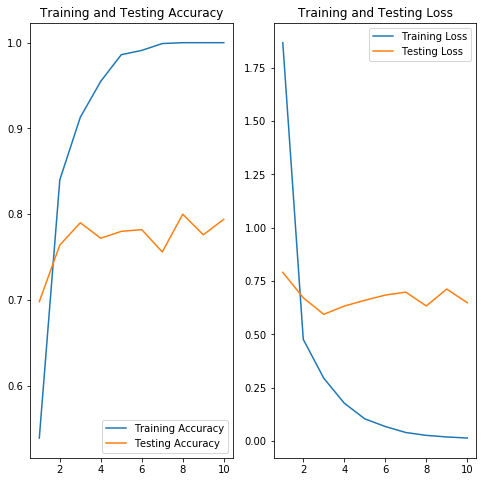

In [0]:
acc = history.history['accuracy']
val_accuracy = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_accuracy, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()

# Part 2 - Landmark Identifier:

In [0]:
cd ..

/gdrive/My Drive/PaceCourses/Summer2019/DeepLearning/Assignments/Assignment2


In [0]:
cd landmarks

/gdrive/My Drive/PaceCourses/Summer2019/DeepLearning/Assignments/Assignment2/landmarks


In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os

import tensorflow as tf
import zipfile

from tensorflow.keras.applications import VGG16
from tensorflow.keras.layers import Conv2D, Dense, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.preprocessing.image import ImageDataGenerator

TARGET_SHAPE = 150 
BATCH_SIZE = 32

FLATTENED_SHAPE = 4 * 4 * 512

EPOCHS = 7

In [0]:
base_building_dir = '/gdrive/My Drive/PaceCourses/Summer2019/DeepLearning/Assignments/Assignment2/landmarks'
train_building_dir = os.path.join(base_building_dir, 'train')
test_building_dir = os.path.join(base_building_dir, 'test')

train_building1_dir = os.path.join(train_building_dir, 'building_1')
train_building2_dir = os.path.join(train_building_dir, 'building_2')
train_building3_dir = os.path.join(train_building_dir, 'building_3')

test_building1_dir = os.path.join(test_building_dir, 'building_1')
test_building2_dir = os.path.join(test_building_dir, 'building_2')
test_building3_dir = os.path.join(test_building_dir, 'building_3')

In [0]:
num_building1_train = len(os.listdir(train_building1_dir))
num_building2_train = len(os.listdir(train_building2_dir))
num_building3_train = len(os.listdir(train_building3_dir))

num_building1_test = len(os.listdir(test_building1_dir))
num_building2_test = len(os.listdir(test_building2_dir))
num_building3_test = len(os.listdir(test_building3_dir))

total_building_train = num_building1_train + num_building2_train + num_building3_train
total_building_val = num_building1_test + num_building2_test + num_building3_test

In [0]:
print('Training building_1 images:', num_building1_train)
print('Training building_2 images:', num_building2_train)
print('Training building_3 images:', num_building3_train)

print('Testing building_1 images:', num_building1_test)
print('Testing building_2 images:', num_building2_test)
print('Testing building_3 images:', num_building3_test)
print('---------')

print('Total training images:', total_building_train)
print('Total testing images:', total_building_val)

Training building_1 images: 22
Training building_2 images: 16
Training building_3 images: 17
Testing building_1 images: 16
Testing building_2 images: 10
Testing building_3 images: 10
---------
Total training images: 55
Total testing images: 36


In [0]:
conv_base = VGG16(weights='imagenet', include_top=False, input_shape=(150, 150, 3))

In [0]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         [(None, 150, 150, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 150, 150, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 150, 150, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 75, 75, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 75, 75, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 75, 75, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 37, 37, 128)       0     

In [0]:
model = Sequential()
model.add(conv_base)
model.add(Flatten())
model.add(Dense(512, activation='relu'))
model.add(Dense(3, activation='softmax'))

In [0]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
vgg16 (Model)                (None, 4, 4, 512)         14714688  
_________________________________________________________________
flatten_1 (Flatten)          (None, 8192)              0         
_________________________________________________________________
dense_2 (Dense)              (None, 512)               4194816   
_________________________________________________________________
dense_3 (Dense)              (None, 3)                 1539      
Total params: 18,911,043
Trainable params: 18,911,043
Non-trainable params: 0
_________________________________________________________________


In [0]:
conv_base.trainable = False

In [0]:
image_gen_train = ImageDataGenerator(rescale=1./255)

train_data_gen = image_gen_train.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=train_building_dir, 
    shuffle=True, 
    target_size=(TARGET_SHAPE,TARGET_SHAPE),
    class_mode='categorical')

image_gen_test = ImageDataGenerator(rescale=1./255)

test_data_gen = image_gen_test.flow_from_directory(
    batch_size=BATCH_SIZE, 
    directory=test_building_dir, 
    target_size=(TARGET_SHAPE, TARGET_SHAPE),
    class_mode='categorical')

Found 55 images belonging to 3 classes.
Found 36 images belonging to 3 classes.


In [0]:
model.compile(optimizer='adam',
              loss='categorical_crossentropy',
              metrics=['accuracy'])

history = model.fit_generator(
      train_data_gen,
      steps_per_epoch=int(np.ceil(total_building_train / float(BATCH_SIZE))),
      epochs=EPOCHS,
      validation_data=test_data_gen,
      validation_steps=int(np.ceil(total_building_val / float(BATCH_SIZE))),
      verbose=2)

Epoch 1/7
2/2 - 36s - loss: 0.8950 - accuracy: 0.4727 - val_loss: 0.1361 - val_accuracy: 0.9444
Epoch 2/7
2/2 - 18s - loss: 0.1194 - accuracy: 0.9636 - val_loss: 0.1432 - val_accuracy: 0.9444
Epoch 3/7
2/2 - 19s - loss: 0.0241 - accuracy: 0.9818 - val_loss: 0.1647 - val_accuracy: 0.9167
Epoch 4/7
2/2 - 19s - loss: 0.0107 - accuracy: 1.0000 - val_loss: 0.3649 - val_accuracy: 0.9167
Epoch 5/7
2/2 - 19s - loss: 0.0105 - accuracy: 1.0000 - val_loss: 0.1539 - val_accuracy: 0.9167
Epoch 6/7
2/2 - 19s - loss: 0.0017 - accuracy: 1.0000 - val_loss: 0.1293 - val_accuracy: 0.9167
Epoch 7/7
2/2 - 19s - loss: 1.4732e-04 - accuracy: 1.0000 - val_loss: 0.1001 - val_accuracy: 0.9444


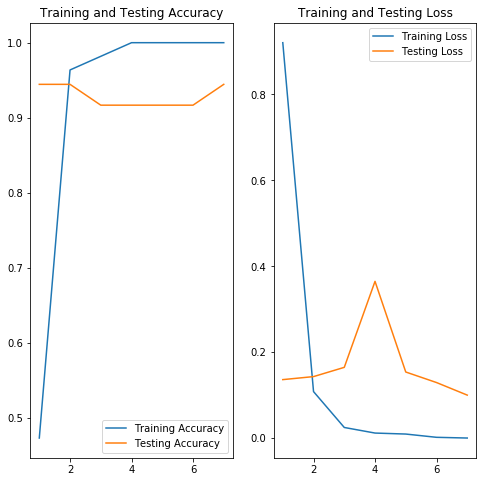

In [0]:
accuracy = history.history['accuracy']
val_acc = history.history['val_accuracy']

loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(1, EPOCHS+1)

plt.figure(figsize=(8, 8))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, accuracy, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Testing Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Testing Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Testing Loss')
plt.legend(loc='upper right')
plt.title('Training and Testing Loss')
plt.show()